# 检查数据
有多少数字是可以直接映射上去的
有多少是映射不上去的
有多少可以映射多个

每个样本，答案中的数字都给出 
- 1 在文本中恰好出现一次， 
- 0 在文本中没有出现
- n 多次出现

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from collections import Counter
from itertools import chain
import copy

In [3]:
import sys


In [4]:
sys.path.append('/Users/caoyixuan/Downloads/实验数据/math_pade_da-master')
sys.path.append('/Users/caoyixuan/dev/UTIE/')
sys.path.append('/Users/caoyixuan/dev/utie_math_problem/')

In [28]:
from src.pre_data import load_raw_data, transfer_num, exchange, allocation, check_bracket, pair_da, allocation, exchange, check_bracket
from utie.common import validation_check
from utie.configuration import Configuration
from utie.data_label_to_candidate import reid
from word_problem.math23k.process import infix_to_postfix, Tree, to_float, eval_postfix, postfix_to_tree, infix_to_relation, add_significant_number, check_num_op, consistent_expression_and_answer, eq_da

In [29]:
eq_o = ['N1', '*', 'N2', '+', 'N3', '*', 'N2']
eq_o = ['(', 'N2', '+', 'N0', ')', '/', 'N1', ]
eq_o = ['(', 'N1', '+', 'N3', ')',  '*', '(', 'N2', '+', 'N0', '+', 'N4', ')']
eqs = eq_da(eq_o, 0.5, english=False)
print(len(eqs))

19


In [30]:
relations = []
for eq in eqs:
    relations.extend(infix_to_relation(eq))

In [31]:
print(len(relations))

110


In [32]:
data = load_raw_data('/Users/caoyixuan/Downloads/实验数据/math_pade_da-master/data/Math_23K.json')

Reading lines...


In [33]:
pairs, generate_nums, copy_nums = transfer_num(data)

Transfer numbers...


In [34]:
print(len(generate_nums), Counter(generate_nums), copy_nums)

2 Counter({'1': 1, '3.14': 1}) 15


In [35]:
words, equ, nums, posi, ans = pairs[0]


# 生成数据标注，把句子中出现的重复实体，在公式中出现的，进行消歧

In [36]:
# idx = '18 282 501 528 938 962 1066 1097 1097 1183 1269 1368 1412 1624 1690 1875 2546 2776 3379 3396 3471 3482 3535 3643 4162 4287 4495 4495 4501 4522 4546 4682 4682 4816 4816 4843 5106 5176 5513 5727 6265 6304 6304 6316 6376 6713 6717 6717 6758 6758 6772 6899 7003 7195 7544 7544 8013 8403 8403 8456 8605 8605 8742 8742 8824 8930 9013 9189 9316 9316 9549 9760 9760 9812 9812 9813 9813 9852 10013 10328 10328 10328 10339 10357 10368 10368 10861 11242 11242 11352 11415 11531 11645 11645 11658 12042 12042 12102 12426 12426 12553 12553 12730 12797 12915 13029 13215 13429 13429 14191 14536 14583 14680 14991 14991 14991 15164 15485 15839 16311 16311 16350 16554 16661 16931 17174 17227 17227 17536 18683 18710 18793 18814 18879 19117 19155 19265 19265 19265 19674 19817 19817 19882 19882 19882 19928 19928 20037 20037 20086 20180 20606 20606 20902 21381 21381 21568 21604 21808 21808 21808 21950 21956 22006 22270 22270 22278 22754 22754 22878 22878'
# wrong_op_index = dict.fromkeys((map(int, idx.split())))
# print(len(wrong_op_index))

In [37]:
# to_label = []
# for I in wrong_op_index:
#     x = pairs[I]
#     # 中括号变成小括号
#     replace_dict = {
#         '[': '(', ']': ')'
#     }
#     infix_expression = x[1]
#     infix_expression = [replace_dict.get(z, z) for z in infix_expression]
#     
#     try:
#         replace_dict = {'N{}'.format(i): to_float(v) for i, v in enumerate(x[2])}  # Ni-> float
#         ans = to_float(x[-1])
#     except:
#         print('fail to float', I, x)
#         continue
#     
#     words = [{'id': f'q-{i}', 'word': w} for i, w in enumerate(x[0])] + [{'id': 'new_line', 'word': '\n'}] + [{'id': f'eq-{i}', 'word': w} for i, w in enumerate(infix_expression)]
#     for num_index, word_index in enumerate(x[3]):
#         words[word_index]['word'] = str(x[2][num_index])
#     
#     eq_entities = []
#     for elei, z in enumerate(infix_expression):
#         if z not in replace_dict and z not in list('+-*/()') + ['1', '3.14']:
#             entity = {'id': f'eq_entity-{elei}', 'type': 'num', 'tokens': f'eq-{elei}'}
#             eq_entities.append(entity)
#     question_entities = [{'id': f'question_entity-{ei}', 'tokens': words[x[3][ei]]['id'], 'type': 'num'} for ei, wi in enumerate(x[3])]
#     sample = {
#         'info': {'sid': str(I)},
#         'words': words,
#         'entities': question_entities + eq_entities,
#         'relations': []
#     }
#     to_label.append(sample)

In [38]:
# json.dump(to_label, open('/Users/caoyixuan/Downloads/tolabel_math23K.json', 'w'))

# 使用标注结果，把答案中的对应关系赋值给 pairs

In [39]:
def sepearate_op(operands):
    if operands[0].startswith('eq_entity') and operands[1].startswith('question_entity'):
        return operands
    else:
        assert operands[1].startswith('eq_entity') and operands[0].startswith('question_entity'), operands
        return operands[::-1]

def reverse_eid(question, answer):
    wid_to_eid = {e['tokens']: e['id'] for e in question['entities']}
    eid_replace = {}  # new id: question id
    for entity in answer['entities']:
        wid = entity['tokens'][0]
        quest_eid = wid_to_eid[wid]
        eid_replace[entity['id']] = quest_eid
        entity['tokens'] = entity['tokens'][0]
    for relation in answer['relations']:
        relation['operands'] = [eid_replace[ans_eid] for ans_eid in relation['operands']]

label = json.load(open('/Users/caoyixuan/dev/utie_math_problem/data/MATH23K_83_correctanswer_20191223_下载193.json'))
# 标注了
for sample in label:
    reverse_eid(sample['question'], sample['answer'])
    sample = sample['answer']
    sample_index = int(sample['info']['sid'])
    pair = pairs[sample_index]
    for relation in sample['relations']:
        eq_entity, ques_entity = sepearate_op(relation['operands'])
        eq_ele_index = int(eq_entity.split('-')[1])
        ques_index = int(ques_entity.split('-')[1])
        
        equation = pair[1]
        print(equation)
        equation[eq_ele_index] = f'N{ques_index}'
        print(equation)
        print(pairs[sample_index][0])

['N1', '-', 'N2', '-', '(', 'N2', '-', '3', ')']
['N1', '-', 'N2', '-', '(', 'N2', '-', 'N3', ')']
['丁丁', '、', '东东', '和', '当', '当', 'NUM', '人', '的', '年龄', '和', '是', 'NUM', '岁', '，', '丁丁', '今年', 'NUM', '岁', '，', '比', '当', '当', '大', 'NUM', '岁', '．', '请问', '：', '东东', '今年', '多少岁', '．']
['4', '+', '1']
['N1', '+', '1']
['有', '白', '、', '黑', '、', '红', '、', '黄', 'NUM', '色', '大小', '一样', '的', '小球', '各', 'NUM', '个', '，', '每次', '至少', '摸', '出', '多少', '个', '，', '才能', '保证', '有', 'NUM', '个', '相同', '颜色', '的', '小球', '．']
['3', '+', '3', '+', '1']
['N0', '+', '3', '+', '1']
['抽屉', '里', '放', '着', '红', '、', '绿', '、', '黄', 'NUM', '种颜色', '的', '球', '各', 'NUM', '只', '．', '一次', '至少', '摸', '出', '多少', '只', '才能', '保证', '每种', '颜色', '至少', '有', '一只', '？']
['N0', '+', '3', '+', '1']
['N0', '+', 'N1', '+', '1']
['抽屉', '里', '放', '着', '红', '、', '绿', '、', '黄', 'NUM', '种颜色', '的', '球', '各', 'NUM', '只', '．', '一次', '至少', '摸', '出', '多少', '只', '才能', '保证', '每种', '颜色', '至少', '有', '一只', '？']
['N0', '+', 'N0', '*', '3', '+', '1']
[

# 解析公式，变成 relations

In [78]:
decimal.Decimal('80') / 100
to_float('1680') / to_float('(7/8)') / to_float('(5/6)')

2304.0

In [74]:
pairs[9]

(['一',
  '个',
  '果园',
  '的',
  '李',
  '树',
  '棵',
  '数',
  '是',
  '桃树',
  '的',
  'NUM',
  '，',
  '桃树',
  '棵',
  '数',
  '是',
  '梨树',
  '的',
  'NUM',
  '．',
  '已知',
  '李树有',
  'NUM',
  '棵',
  '，',
  '梨树',
  '有',
  '多少',
  '棵',
  '？'],
 ['N2', '/', 'N0', '/', 'N1'],
 ['(7/8)', '(5/6)', '1680'],
 [11, 19, 23],
 '2304')

In [79]:
import re
from collections import OrderedDict
mold_json = json.load(open('/Users/caoyixuan/dev/utie_math_problem/data/mold-数学计算-无序-SNI.json'))
mold = Configuration(mold_json)

eq_data_aug = True
new_data = []
for I, x in enumerate(pairs):
    if I == 8882:
        continue
    
    infix_expression = x[1]
    if eq_data_aug:
        relations = []
        if '+' in x[0] or '*' in x[0] or '-' in x[0]:
            infix_expressions = [infix_expression]
        else:
            infix_expressions = list(eq_da(infix_expression, 0.5, False))
        assert isinstance(infix_expressions[0], (list, tuple)), (infix_expressions, type(infix_expressions[0]))
        for one_eq in infix_expressions:
            # print(one_eq)
            relations.extend(infix_to_relation(one_eq))
        success, consistent, ans_v = consistent_expression_and_answer(x[2], infix_expressions[0], x[-1])
    else:
        relations = infix_to_relation(infix_expression)
        success, consistent, ans_v = consistent_expression_and_answer(x[2], infix_expression, x[-1])
    if not success:
        continue
    if not consistent:
        print('answer inconsistent', I, ans_v)
        
    w1 = {'word': '1', 'id': 'sp1'}
    e1 = {'id': '1', 'tokens': 'sp1', 'type': 'num'}
    w_pi = {'word': 'π', 'id': 'sp_pi'}
    e_pi = {'id': '3.14', 'tokens': 'sp_pi', 'type': 'num'}

    w_dict = {'”': '"', '“': '"', u'”': '"', u'“': '"', u'NUM': 'n', '\u3000': ' ', '\uff1f': ' '}
    sample = {
        'info': {'sid': str(I), 'q': x},
        'words': [{'word': w_dict.get(w, w), 'id': str(i)} for i, w in enumerate(x[0])] + [w1, w_pi],
        'entities': [{'id': 'N{}'.format(i), 'tokens': str(v), 'type': 'num'} for i, v in enumerate(x[3])] + [e1, e_pi],
        'relations': relations
    }
    add_significant_number(sample)
    valid, fail_info = check_num_op(sample)
    if valid:
        sample = reid(sample, unordered_types=['+', '*'], readable=False)
        sample['relations'] = list(OrderedDict((r['id'], r) for r in sample['relations']).values())
        validation_check(sample)
        new_data.append(sample)
    else:
        print(f'{I}, {fail_info}', ''.join(x[0]), x[2])

!!! -------- you should configure expression_types 
501, invalid op: 4 in {'id': 'e0', 'operands': ['4', 'N0'], 'type': '*'} 一辆汽车每小时行驶NUM千米．从甲地到乙地，共行驶l4小时．甲地到乙地有多少千米？ ['165']
4162, invalid op: 3 in {'id': 'e0', 'operands': ['N1', '3'], 'type': '*'} 用NUM、NUM、NUM这NUM个数字和小数点，可以组成多少个不同的两位小数． ['1', '2', '3', '3']
answer inconsistent 4302 (1010000.0, 1009899.0)
4495, invalid op: 4 in {'id': 'e5', 'operands': ['e4', '4'], 'type': '*'} 一个教室的长是NUM米，宽是NUM米，高是NUM米．要粉刷教室的天花板和NUM周，除去门窗面积NUM米^NUM，要粉刷多大的面积？ ['8', '6', '4', '4', '30', '2']
4522, invalid op: 10 in {'id': 'e1', 'operands': ['e0', '10'], 'type': '/'} 一个NUM岁的儿童每天需要NUM毫克的维生素C，已知某果汁每NUM克含维生素C10毫克，需要喝这种果汁多少克才能满足一天所需的维生素C． ['12', '50', '25']
4682, invalid op: 4 in {'id': 'e1', 'operands': ['N2', '4'], 'type': '*'} 有一正方形操场，每边都栽种NUM棵树，NUM个角各种NUM棵．问共种树多少棵？ ['4', '4', '1']
5727, invalid op: 5 in {'id': 'e1', 'operands': ['e0', '5'], 'type': '*'} 用NUM、NUM、NUM、NUM、NUM、NUM个数字，能组成多少个没有重复数字的NUM位数． ['0', '1', '2', '3', '4', '56', '3']
7544, invalid op:

In [53]:
import decimal
#decimal.Decimal(x)                                          #x可以是一个整数或字符串，但不能是浮点数
import decimal
a = decimal.Decimal(9876)
b = decimal.Decimal("54321.01234567898754321")
print(a + b)
 
print(decimal.Decimal.from_float(0.1))                              #x可以是一个浮点数
print(decimal.Decimal('0.1'))                              #x可以是一个浮点数
# print(Decimal('0.1000000000000000055511151231257827021181583404541015625'))


64197.01234567898754321
0.1000000000000000055511151231257827021181583404541015625
0.1


In [64]:

x = decimal.Decimal(0.1 / 100)
print(x)
x = decimal.Decimal('0.1') / 100
print(x)
print(float(x))
print(decimal.Decimal(float(x)))

0.001000000000000000020816681711721685132943093776702880859375
0.001
0.001
0.001000000000000000020816681711721685132943093776702880859375


In [34]:
isinstance([0], (tuple, list))

True

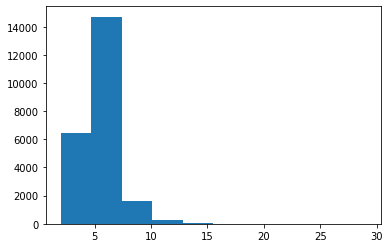

In [23]:
from matplotlib import pyplot as plt
plt.hist([len(s['relations']) for s in new_data])
plt.show()

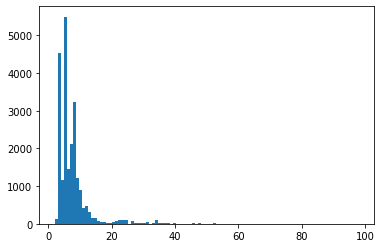

1213


In [55]:
import numpy as np
lens = np.asarray([len(s['relations']) for s in new_data])
plt.hist(lens[lens<100], 100)
plt.show()
print(sum(lens>20))

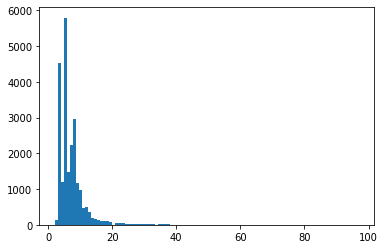

481
6
264


In [59]:
import numpy as np
lens = np.asarray([len(s['relations']) for s in new_data])
plt.hist(lens[lens<100], 100)
plt.show()
print(sum(lens>20))
print(sum(lens>100))
print(max(lens))

In [53]:
for s in new_data:
    l = len(s['relations'])
    if l > 100:
        if l < 1000:
            print(s['info'], l)
        else:
            print('---------')
            print(s['info'], l)

{'sid': '44', 'q': (['一', '台', '电视机', '原价', 'NUM', '元', '．', '提价', 'NUM', '后', '又', '降价', 'NUM', '．', '现在', '电视机', '卖', '多少', '钱', '一台', '？'], ['N0', '*', '(', '1', '+', 'N1', ')', '*', '(', '1', '-', 'N2', ')'], ['1600', '(3/10)', '(1/5)'], [4, 8, 12], '1664')} 203
{'sid': '85', 'q': (['一', '款', '原价', 'NUM', '元', '的', '空调', '先后', '两次', '降价', '，', '第一次', '降价', 'NUM', '，', '第', '二', '次', '又', '降价', 'NUM', '．', '现在', '这', '款', '空调', '的', '售价', '=', '多少', '元', '？'], ['N0', '*', '(', '1', '-', 'N1', ')', '*', '(', '1', '-', 'N2', ')'], ['3000', '10%', '5%'], [3, 13, 20], '2565')} 200
{'sid': '145', 'q': (['一', '个', '长方体', '水箱', '，', '长', '为', 'NUM', '分', '米', '，', '宽', '为', 'NUM', '分', '米', '，', '高', '为', 'NUM', '分', '米', '，', '装', '水', '高', 'NUM', '分', '米', '，', '现在', '把', '一块', '长', 'NUM', '分', '米', '，', '宽', 'NUM', '分', '米', '的', '长方体', '铁块', '浸没', '在', '水箱', '中', '，', '这时', '水面', '高', 'NUM', '分', '米', '．', '求', '这个', '铁块', '的', '高', '=', '多少', '分', '米', '？'], ['N0', '*', 'N1', '*', '('

In [178]:
len(new_data), len(new_data) /  len(data)

(23143, 0.9991796908729816)

In [181]:
new_data[1]

{'info': {'sid': '1',
  'q': (['一',
    '个',
    '工程队',
    '挖土',
    '，',
    '第一天',
    '挖',
    '了',
    'NUM',
    '方',
    '，',
    '从',
    '第',
    '二',
    '天',
    '开始',
    '每天',
    '都',
    '挖',
    'NUM',
    '方',
    '，',
    '连续',
    '挖',
    '了',
    'NUM',
    '天',
    '，',
    '这个',
    '工程队',
    '一周',
    '共',
    '挖土',
    '多少',
    '方',
    '？'],
   ['N0', '+', 'N1', '*', '(', 'N2', '-', '1', ')'],
   ['316', '230', '6'],
   [8, 19, 25],
   '1466')},
 'words': [{'word': '一', 'id': '0'},
  {'word': '个', 'id': '1'},
  {'word': '工程队', 'id': '2'},
  {'word': '挖土', 'id': '3'},
  {'word': '，', 'id': '4'},
  {'word': '第一天', 'id': '5'},
  {'word': '挖', 'id': '6'},
  {'word': '了', 'id': '7'},
  {'word': 'n', 'id': '8'},
  {'word': '方', 'id': '9'},
  {'word': '，', 'id': '10'},
  {'word': '从', 'id': '11'},
  {'word': '第', 'id': '12'},
  {'word': '二', 'id': '13'},
  {'word': '天', 'id': '14'},
  {'word': '开始', 'id': '15'},
  {'word': '每天', 'id': '16'},
  {'word': '都', 'id': '

In [188]:
json.dump(new_data, open('/Users/caoyixuan/Downloads/实验数据/math_pade_da-master/data/Math_23K_utie_SNI.json', 'w'))

In [185]:

import random
random.shuffle(new_data)
n_d_5 = len(new_data) // 5

for i in range(5):
    s, e = i * n_d_5, (i + 1) * n_d_5
    one_slice = new_data[s: e]
    print(len(one_slice))
    json.dump(one_slice, open(f'/Users/caoyixuan/Downloads/实验数据/math_pade_da-master/data/Math_23K_utie_SNI-{i}.json', 'w'))

4628
4628
4628
4628
4628


In [207]:
rtypes = []
for s in new_data:
    types = [r['type'] for r in s['relations']]
    if '^' in types:
        print(s)
        break
    rtypes.extend(types)
Counter(rtypes)

{'info': {'sid': '199', 'q': (['NUM', '+', 'NUM', '^', 'NUM', '．'], ['N0', '+', 'N1', '^', 'N2'], ['1999', '999', '2'], [0, 2, 4], '1000000')}, 'words': [{'word': 'n', 'id': '0'}, {'word': '+', 'id': '1'}, {'word': 'n', 'id': '2'}, {'word': '^', 'id': '3'}, {'word': 'n', 'id': '4'}, {'word': '．', 'id': '5'}, {'word': '1', 'id': 'sp1'}, {'word': 'π', 'id': 'sp_pi'}], 'entities': [{'id': 'N0', 'tokens': '0', 'type': 'num'}, {'id': 'N1', 'tokens': '2', 'type': 'num'}, {'id': 'N2', 'tokens': '4', 'type': 'num'}, {'id': '1', 'tokens': 'sp1', 'type': 'num'}, {'id': '3.14', 'tokens': 'sp_pi', 'type': 'num'}], 'relations': [{'id': 'e0', 'operands': ['N1', 'N2'], 'type': '^'}, {'id': 'e1', 'operands': ['N0', 'e0'], 'type': '+'}, {'id': 'SNI-N0', 'operands': ['N0'], 'type': 'S'}, {'id': 'SNI-N1', 'operands': ['N1'], 'type': 'S'}, {'id': 'SNI-N2', 'operands': ['N2'], 'type': 'S'}]}


Counter({'-': 115, '*': 141, 'S': 609, '+': 88, '/': 137})

In [107]:
73/23162.*100

0.3151714014333823

In [108]:
n1 = 0
npi = 0
operands = []
for s in new_data:
    for r in s['relations']:
        if '1' in r['operands']:
            n1 += 1
        if '3.14' in r['operands']:
            npi +=1 
        if '3' in r['operands']:
            print(s)
            break
        operands.extend(r['operands'])
print(n1, npi)
Counter(operands).most_common()

11115 494


[('N0', 47062),
 ('N1', 45864),
 ('N2', 28514),
 ('e0', 18408),
 ('1', 11140),
 ('N3', 6967),
 ('e1', 6926),
 ('e2', 2357),
 ('N4', 1582),
 ('e3', 959),
 ('N5', 512),
 ('3.14', 494),
 ('e4', 368),
 ('N6', 190),
 ('e5', 154),
 ('N7', 105),
 ('e6', 81),
 ('N8', 60),
 ('e7', 38),
 ('N9', 36),
 ('N10', 16),
 ('e8', 15),
 ('N11', 10),
 ('e9', 8),
 ('e10', 3),
 ('e11', 3),
 ('N12', 2),
 ('N13', 2),
 ('e12', 2),
 ('N14', 2),
 ('e13', 1),
 ('e14', 1),
 ('e15', 1),
 ('e16', 1),
 ('e17', 1),
 ('e18', 1)]

In [ ]:
(256 + 86 + 45 + 21 + 19 + 2 + 1 + 1 + 1) / len(data) * 100


In [66]:
x = (md5.hexdigest())

In [67]:
ord('aa')

TypeError: ord() expected a character, but string of length 2 found

In [69]:
d = sum([ord(c) for c in x[:4]])
print(d)
print(d%3)

253
1


In [105]:
md5 = hashlib.md5(str(123).encode('utf8'))

In [99]:
x = []
for i in range(100000):
    md5 = hashlib.md5(str(i).encode('utf8')).hexdigest()
    d = sum([ord(c) for c in md5 if ord(c)<60][:3])  # ord('9')=57
    x.append(d)

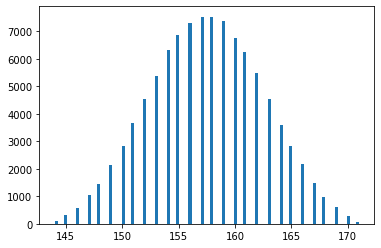

In [101]:
from matplotlib import pyplot as plt
# plt.hist([xx%10 for xx in x], 100)
plt.hist(x, 100)
plt.show()

In [54]:
'616d45472bd5212c5c34b7b656ced8f1' % 3

TypeError: not all arguments converted during string formatting